In [10]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem

In [12]:
# symbols = ["H", "H"]
# geometry = np.array([[0., 0., -0.66140414], [0., 0., 0.66140414]])
mol_LiH = qchem.Molecule(["Li", "H"], np.array([[0, 0, 0], [0, 0, 1.547]]))
electrons = 4
hamiltonian, qubits = qchem.molecular_hamiltonian(mol_LiH)

In [14]:
hf = qchem.hf_state(electrons, qubits)
singles, doubles = qchem.excitations(electrons=electrons, orbitals=qubits)
num_theta = len(singles) + len(doubles)


def circuit_VQE(theta, wires):
    qml.AllSinglesDoubles(
        weights=theta, wires=wires, hf_state=hf, singles=singles, doubles=doubles
    )


In [82]:
dev = qml.device("lightning.qubit", wires=qubits)


@qml.qnode(dev, interface="autograd")
def cost_fn(theta):
    circuit_VQE(theta, range(qubits))
    return qml.expval(hamiltonian)


stepsize = 0.4
max_iterations = 50
opt = qml.GradientDescentOptimizer(stepsize=stepsize)
theta = np.zeros(num_theta, requires_grad=True)

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)
    # samples = cost_fn(theta)

energy_VQE = cost_fn(theta)
theta_opt = theta

print("VQE energy: %.4f" % (energy_VQE))
# print("Optimal parameters:", theta_opt)

VQE energy: -7.6534


In [77]:
# new_ham = hamiltonian + 10 * np.atleast_2d(np.array(theta_opt)).conj().T @ np.atleast_2d(np.array(theta_opt))

# def sim_En_1():
#     dev = qml.device("lightning.qubit", wires=qubits)

#     @qml.qnode(dev, interface="autograd")
#     def cost_fn(theta):
#         circuit_VQE(theta, range(qubits))
#         return qml.expval(new_ham)

#     stepsize = 0.4
#     max_iterations = 30
#     opt = qml.GradientDescentOptimizer(stepsize=stepsize)
#     theta = np.zeros(num_theta, requires_grad=True)

#     for n in range(max_iterations):
#         theta, prev_energy = opt.step_and_cost(cost_fn, theta)
#         # samples = cost_fn(theta)

#     energy_VQE = cost_fn(theta)
#     theta_opt = theta

#     print("VQE energy: %.4f" % (energy_VQE))

# Molecule Parameters:
# symbols_lih = ["Li", "H"]
# geometry_lih = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 2.969280527])
# qchem.Molecule(["Li", "H"], np.array([[0, 0, 0], [0, 0, 1.547]]))
# Hamiltonian:
# hamiltonian_lih, qubits_lih =  qml.qchem.molecular_hamiltonian(
#         symbols_lih,
#         geometry_lih,
#         active_electrons=2,
#         active_orbitals=2
# )

def WEIGHTED_SSVQE(
    hamiltonian,
    ansatz,
    params,
    opt_name="Adam",
    stepsize=0.1,
    iterations=100,
    k=0,
    device_name="default.qubit",
):
    """Calculates the kth excited state energy for of a given Hamiltonian.

    Args:
        => hamiltonian (qml.Hamiltonian): Hamiltonian for which the Kth excited state energy is to be found.
        => ansatz (function(params, wires, *args)): The circuit ansatz for which the cost function will be optimized.
           ansatz must have atleast two arguments 'params' and 'wires'.
           There is no need to prepare orthogonal basis stats, they will be prepared by the algorithm.
        => params (any): Parameters that can be passed to the provided ansatz.
        => opt_name(string): Name of the optimizer to use for optimization.
           Currently the function supports 'Adam' 'Adagrad' 'GradientDescent'.
        => stepsize (float): Stepsize for the optimizer.
        => iterations (int): No. of Iterations for the optimization.
        => k (int): K for which the Kth excited state energy will be calculated. K <= 2^qubits-1.
        => device_name(string): device name for creating device such that qml.device(device_name, wires=wires).
    Returns:
        => (Energy, Energies): The function returns a tuple of Energy of Kth excited state and list of energies at each iteration for plotting the graph.
    """

    # Calculate number of qubits required for the given Hamiltonian and create the device.
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits)
    wires = range(qubits)

    # Define the weights for the cost function.
    weights = np.random.random()

    # State Preparation for orthogonal states.
    def state_prep(state_value):
        for index, value in enumerate(np.binary_repr(state_value, qubits)):
            if value == "1":
                qml.PauliX(index)

    # Cost of each orthogonal state.
    @qml.qnode(device)
    def state_cost(params, state_value):
        state_prep(state_value)
        ansatz(params, wires)
        return qml.expval(hamiltonian)

    # Total cost of the system.
    def total_cost(params):
        cost = 0
        for index in range(k + 1):
            if index == k:
                cost += weights * state_cost(params, state_value=index)
            else:
                cost += state_cost(params, state_value=index)
        return cost

    # Optimizers options.
    optimizers = {
        "Adam": qml.AdamOptimizer(stepsize=stepsize),
        "Adagrad": qml.AdagradOptimizer(stepsize=stepsize),
        "GradientDescent": qml.GradientDescentOptimizer(stepsize=stepsize),
    }

    # Define the Optimizer and initial parameters.
    optimizer = optimizers[opt_name]
    energies = []

    # Optimization loop.
    for _ in range(iterations):
        params = optimizer.step(total_cost, params)
        energy = state_cost(params, state_value=k)
        energies.append(energy)
    return energies[-1], energies


# energy_G_1, energies_G_1 = WEIGHTED_SSVQE(hamiltonian_lih, ansatz, params_lih, stepsize=0.05, k=0)
# energy_1_1, energies_1_1 = WEIGHTED_SSVQE(hamiltonian_lih, ansatz, params_lih, stepsize=0.05, k=1)
# print('Energy of Ground state for the LiH hamiltonian is:', energy_G_1)
# print('Energy of First Excited state for the H2 hamiltonian is:', energy_1_1)
# print()

KeyboardInterrupt: 

In [81]:
hamiltonian_lih, qubits_lih = qchem.molecular_hamiltonian(mol_LiH)

# Params:
params_lih = np.random.uniform(0, 2 * np.pi, (6, qubits_lih, 3))
def ansatz(params, wires):
    qml.templates.StronglyEntanglingLayers(params, wires=wires)

energy_G_1, energies_G_1 = WEIGHTED_SSVQE(hamiltonian_lih, ansatz, params_lih, stepsize=0.4, iterations=30, k=0)
print('Energy of Ground state for the LiH hamiltonian is:', energy_G_1)
print(energies_G_1)
energy_1_1, energies_1_1 = WEIGHTED_SSVQE(hamiltonian_lih, ansatz, params_lih, stepsize=0.4, iterations=30, k=1)
print('Energy of First Excited state for the LiH hamiltonian is:', energy_1_1)
print(energies_1_1)

Energy of Ground state for the LiH hamiltonian is: -3.9908181984991336
[tensor(-3.85089791, requires_grad=True), tensor(-3.8562052, requires_grad=True), tensor(-3.86148685, requires_grad=True), tensor(-3.8667411, requires_grad=True), tensor(-3.87196642, requires_grad=True), tensor(-3.87716143, requires_grad=True), tensor(-3.88232492, requires_grad=True), tensor(-3.88745582, requires_grad=True), tensor(-3.89255318, requires_grad=True), tensor(-3.89761616, requires_grad=True), tensor(-3.90264401, requires_grad=True), tensor(-3.90763604, requires_grad=True), tensor(-3.91259165, requires_grad=True), tensor(-3.91751025, requires_grad=True), tensor(-3.92239132, requires_grad=True), tensor(-3.92723436, requires_grad=True), tensor(-3.9320389, requires_grad=True), tensor(-3.93680447, requires_grad=True), tensor(-3.94153066, requires_grad=True), tensor(-3.94621703, requires_grad=True), tensor(-3.95086321, requires_grad=True), tensor(-3.95546882, requires_grad=True), tensor(-3.9600335, requires_g

In [28]:
@qml.qnode(dev)
def my_circ(time: float):
    # Prepare some state
    # qml.Hadamard(0)
    circuit_VQE(theta, range(qubits))
    # Evolve according to H
    qml.QDrift(hamiltonian, time=time, n=10, seed=10)

    return qml.expval(hamiltonian)


In [29]:
# print(my_circ())

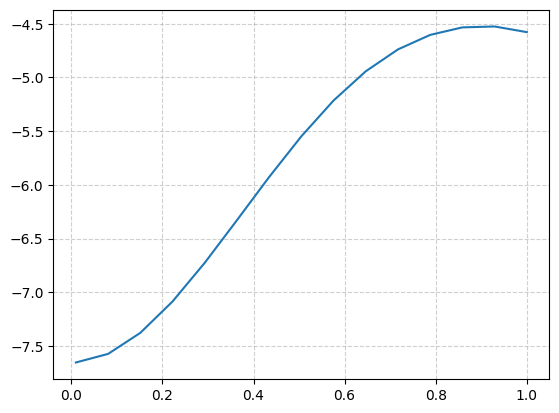

In [80]:
import matplotlib.pyplot as plt

# plot res using the matplotlib library with 4 lines on the same graph over the time np.linspace(0.01, 1.0, 4)
timesteps = np.linspace(0.01, 1, 15)
# result = np.hstack([np.atleast_2d(simulate_molecule(mol_LiH, t)).T for t in timesteps])
# plt.plot(timesteps, *result)
# for r in result:
plt.plot(timesteps, [my_circ(t) for t in timesteps])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
# plt.show()

In [8]:
dev = qml.device("default.qubit", wires=qubits)


@qml.qnode(dev)
def circuit(params):
    qml.BasisState(np.array([1, 1, 0, 0]), wires=qubits)
    qml.DoubleExcitation(params, wires=qubits)
    return qml.expval(hamiltonian)


params = np.array(0.20885146442480412, requires_grad=True)
circuit(params)


ValueError: State must be of length 1; got length 4 (state=[1 1 0 0]).